# Tweets related to citizenship S1. 25/1/2018 - 31/1/2018

The following will analyse a preprocessed dataset of around 65,000 tweets collected between 25/1/2018 - 31/1/2018. These have been sourced using twitters streaming API.

Terms Tracked: 'citizen', 'citizenship'.

In [2]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from IPython.core.display import HTML, display

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,5)

df = pd.read_csv("../data/twitter/tweets_nodate_train", na_filter=False)
df.text.fillna('', inplace=True)

The Dataset can be described as follows. Object types within the columns are strings of words seperated by spaces and containing no punctuation. 

In [3]:
# display(df.head(3))
print(df.dtypes)
print("\nNumber of (rows, cols):", df.shape)

text                object
polarity           float64
subjectivity       float64
tags                object
tag_count            int64
mentioned           object
mentioned_count      int64
dtype: object

Number of (rows, cols): (66440, 7)


# Strategy and Starting questions

* How well do theoretical conceptions of citizenship describe the dataset?
* What are the main topics of the dataset and how episodic are they?
* General sentiment presented here?
* How is citizenship related to the topics presented in the data?

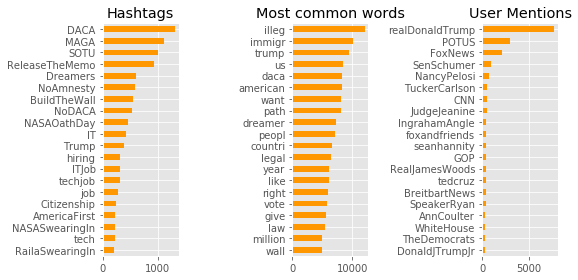

In [3]:
top_n = 20

def plot_counts(col, top_n=top_n, **kwargs):
    c = df[col].str.split(expand=True).stack().value_counts()
    for s in stopwords:
        del c[s]
    c[:top_n].plot(kind="barh", **kwargs).invert_yaxis()

stopwords = set(["citizen", "citizenship"])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(8, 4)

plot_counts("tags", ax=ax1, title="Hashtags", color="#FF9800")
plot_counts("text", ax=ax2, title="Most common words", color="#FF9800")
plot_counts("mentioned", ax=ax3, title="User Mentions", color="#FF9800")

plt.tight_layout()
plt.show()

## Ngram frequencies

We can see how often sequences of words appear together in the data providing slightly more description that just counting word occurance. 

In [5]:
def plot_ngrams(n0, n1, n_features=1000, filter_fn=None):
    z = n1 - n0
    fig, axis = plt.subplots(1, z)
    fig.set_size_inches(10, 5)
    for i in range(z):
        tfidf_vect = TfidfVectorizer(max_df=0.5, min_df=2, 
                                     max_features=n_features,
                                     ngram_range=(n0 + i, n0 + i + 1))
        tfidf_features = tfidf_vect.fit_transform(df.text)
        vocab = tfidf_vect.get_feature_names()
        values = tfidf_features.toarray().sum(axis=0)
        if filter_fn:
            sample = [(values[i], k) for i, k in enumerate(vocab) if filter_fn(k)]
        else:
            sample = [(values[i], k) for i, k in enumerate(vocab)]
        v, k = zip(*sorted(sample, reverse=True)[:20])
        dd = pd.DataFrame(index=k, data={"key": k, "tfidf": v})
        dd.plot(kind="barh", ax=axis[i], color="#FF9800", legend=False).invert_yaxis()
    plt.tight_layout()
    plt.show()


def word_end(word): 
    def f(k): 
        return k.endswith(word)
    return f

def word_start(word): 
    def f(k): 
        return k.startswith(word)
    return f

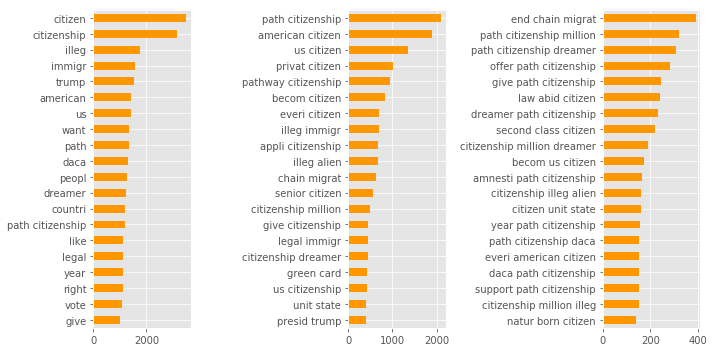

In [6]:
plot_ngrams(1, 4)

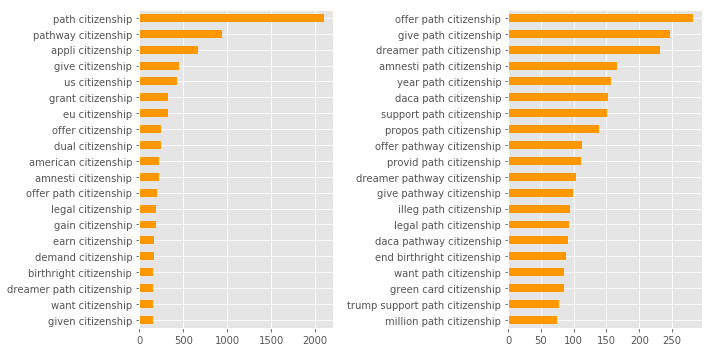

In [7]:
plot_ngrams(2, 4, filter_fn=word_end("citizenship"))

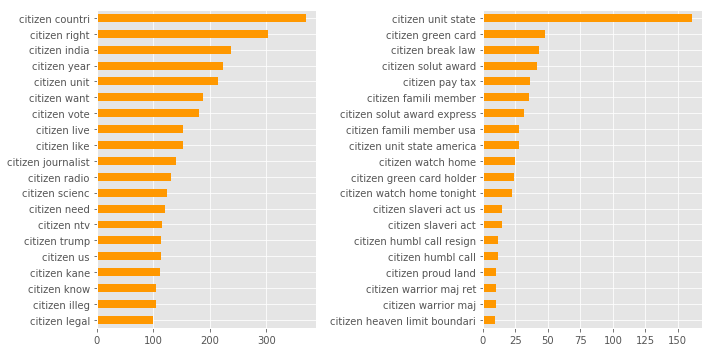

In [8]:
plot_ngrams(2, 4, filter_fn=word_start("citizen "))

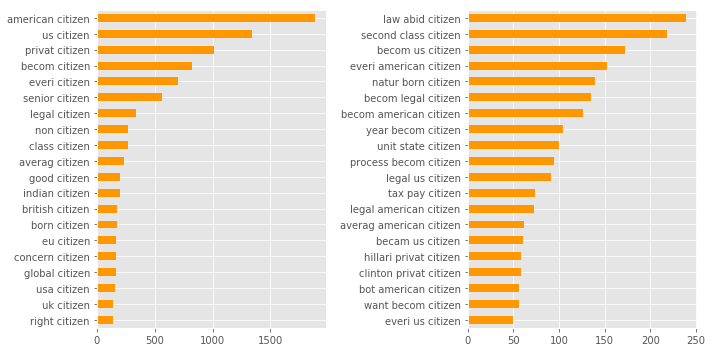

In [9]:
plot_ngrams(2, 4, filter_fn=word_end("citizen"))

## Topic & Feature Extraction

As a starting point we can use hashtags, user mentions and most common words in the tweets to discern some overarching themes within the tweets. I'm not sure what method can be used to find how episodic the content is, but presume that it will have something to do with Tf-idf. 

https://pdfs.semanticscholar.org/5b5c/a878c534aee3882a038ef9e82f46e102131b.pdf
http://text-analytics101.rxnlp.com/2015/11/understanding-text-similarity.html

In [10]:
n_features = 5000
n_topics = 5
n_samples = 40

def print_top_words(model, feature_names, n_top_words):
    ol = [", ".join([feature_names[i]
                     for i in topic.argsort()[:-n_top_words - 1:-1]])
         for topic_idx, topic in enumerate(model.components_)]
    display(HTML("<ol><li>{}</li></ol>".format("</li><li>".join(ol))))

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, 
                                   max_features=n_features,
                                   ngram_range=(1,4))

tfidf_features = tfidf_vectorizer.fit_transform(df.text.astype(str))
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [12]:
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features,\nnumber of topics=%d\nn_samples=%d and n_features=%d..." 
      % (n_topics, n_samples, n_features))

t0 = time.time()
nmf = NMF(n_components=n_topics, random_state=1,
          beta_loss='kullback-leibler', solver='mu', 
          max_iter=10000, alpha=.1, l1_ratio=.5).fit(tfidf_features)
print("time: {:.2f} secs".format(time.time() - t0))

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features,
number of topics=5
n_samples=40 and n_features=5000...
time: 39.00 secs


In [15]:
display(HTML("<h3>Topics Generated by NMF Model</h3>"))
print_top_words(nmf, tfidf_feature_names, n_samples)

# NMF model qualitative sumary

All different subsets of discussions od DACA

Can see more with ngrams, starting to see bits of arguments about the topic, but still kinda not fully, the main thing noted is all the different types of citizenship labeled.

In [10]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=10,
                                max_features=n_features,
                                stop_words='english')

tf_features = tf_vectorizer.fit_transform(df.text)
tf_feature_names = tf_vectorizer.get_feature_names()
print('Number of unique words:', len(tf_feature_names))

Number of unique words: 5000


In [11]:
print("Fitting LDA models with tf features, "
      "\nnumber of topics=%d\nn_samples=%d and n_features=%d..."
      % (n_topics, n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time.time()
lda.fit(tf_features)
print("time: {:.2f} secs".format(time.time() - t0))

Fitting LDA models with tf features, 
number of topics=5
n_samples=20 and n_features=5000...
time: 666.68 secs


In [25]:
display(HTML("<h3>Topics Generated by LDA model</h3>"))
print_top_words(lda, tf_feature_names, n_samples)

## Bad words.

In [13]:
with open("../utils/badwords.txt") as f:
    badwords = set([w.lower() 
                    for w in f.read().split("\n") 
                    if " " not in w and len(w) > 2])

In [14]:
def count_bad(tweet):
    return int(any(((b in tweet) for b in badwords)))

bad_tweets = df.text.apply(count_bad).sum()
print(bad_tweets)
print("tweets containing profanity: {:.2f}%".format(bad_tweets / len(df) * 100))

14214
tweets containing profanity: 21.39%


In [1]:
# 
from nltk.corpus import twitter_samples
print(twitter_samples.fileids())

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']
